In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import polars as pl
import time
import pandas as pd
import numpy as np

## Get All Meeting Page Links

### Check Project Flow

In [4]:
og = pd.read_csv('../Data_Raw/project_tables/og_geocoded.csv')

Group all projects by the number of steps that exist for it.

In [26]:
n_steps = og.groupby(['project_number']).size()
n_steps.groupby(n_steps).count()

1     3667
2     2647
3      527
4      163
5       34
6        7
7        5
10       1
dtype: int64

Get a project from each group based on the number of steps involved in it. Look at the Google Doc for explanations on each project to understand the steps.

In [49]:
np.random.seed(42)

for i in range(1,max(n_steps) + 1):
    if len(n_steps[n_steps == i]) > 0:
        print(i, np.random.choice(n_steps[n_steps == i].index.values, replace=False))
    else:
        print(i, "No samples available")

1 OG 09-266
2 OG 15-287
3 OG 23-150
4 OG 19-155
5 OG 17-095
6 OG 16-309
7 OG 18-075
8 No samples available
9 No samples available
10 OG 19-186


In [56]:
og[og['project_number'] == 'OG 23-150']

,project_number,project_link,project_type,project_description,last_reviewed,last_reviewed_meeting,review_type,project_location_clean,project_location_preload_geolocator,Coordinates,Coordinates_lat_lon,Coordinates_full
1242,OG 23-150,/records-research/project-search/og-23-150-1,Commercial,Signage for Streets Market,2023-05-18T12:00:00Z,/records-research/record-cfa-actions/2023/05/c...,(CFA Meeting - OG Appendix),2617 p street nw,"2617 p street nw, washington, district of colu...","7-Eleven, 2617, P Street Northwest, Peter Squa...","(38.90956075, -77.05533405600275)","{'place_id': 319843046, 'licence': 'Data © Ope..."
1265,OG 23-150,/records-research/project-search/og-23-150-0,Commercial,Signage for Streets Market,2023-05-04T12:00:00Z,/records-research/record-cfa-actions/2023/05/o...,(OGB Meeting - Consent Calendar),2617 p street nw,"2617 p street nw, washington, district of colu...","7-Eleven, 2617, P Street Northwest, Peter Squa...","(38.90956075, -77.05533405600275)","{'place_id': 319843046, 'licence': 'Data © Ope..."
1365,OG 23-150,/records-research/project-search/og-23-150,Commercial,Signage for Streets Market,2023-04-06T12:00:00Z,/records-research/record-cfa-actions/2023/04/o...,(OGB Meeting - Agenda),2617 p street nw,"2617 p street nw, washington, district of colu...","7-Eleven, 2617, P Street Northwest, Peter Squa...","(38.90956075, -77.05533405600275)","{'place_id': 319843046, 'licence': 'Data © Ope..."


I am changing my strategy. Instead of going through each individual project page (project-search), I am going to go to the record-cfa-actions to find each individual meeting, then can link the information for each of the steps.

### Scrape /records-research/record-cfa-actions/

#### Page Image

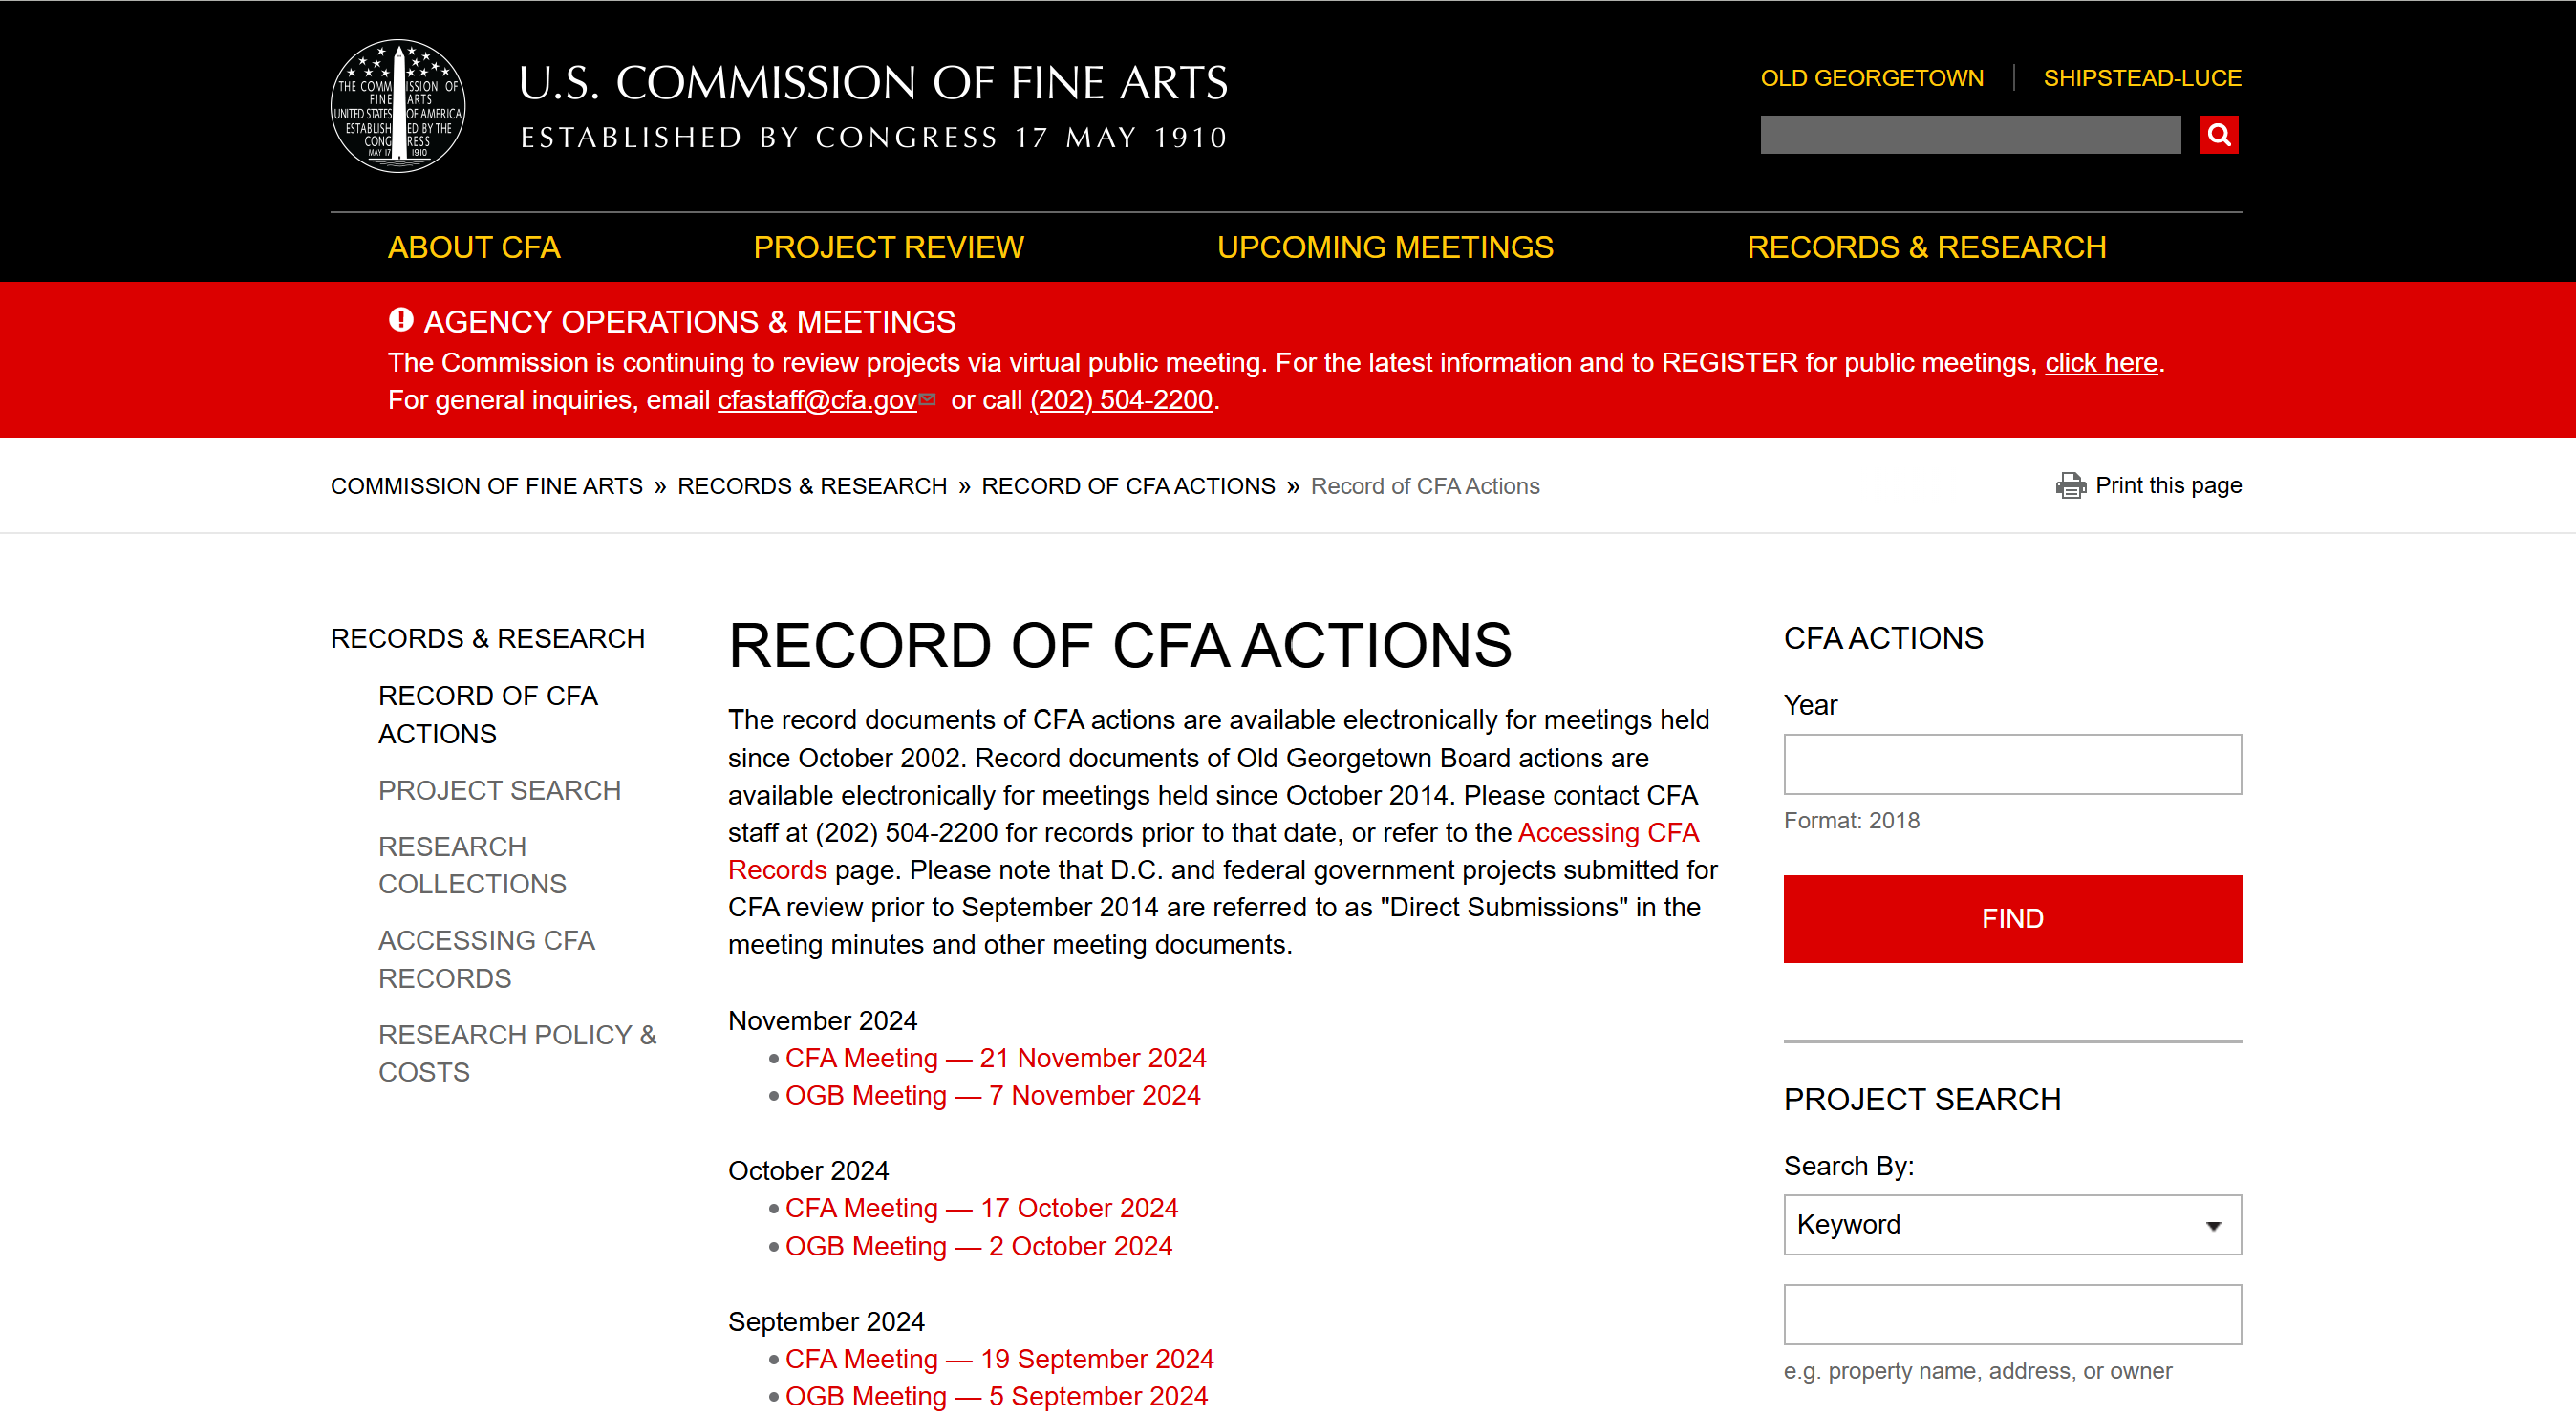

#### **Functions**

In [29]:
def start_driver(url,add_cfa=False,options=None,current_driver=None):
    """
    Initializes a Chrome WebDriver instance and navigates to the specified URL.
    Args:
        url (str): The URL to navigate to after starting the WebDriver.
        add_cfa (bool, optional): If True, prepends "https://www.cfa.gov" to the URL. Defaults to False.
        options (webdriver.ChromeOptions, optional): Chrome options to configure the WebDriver. Defaults to None.
        current_driver (WebDriver, optional): An existing WebDriver instance to use instead of creating a new one. Defaults to None.
    Returns:
        WebDriver: An instance of the Chrome WebDriver.
    """
    if add_cfa:
        url = f"https://www.cfa.gov{url}"

    if current_driver is not None:
        current_driver.get(url)
        return current_driver
    else:
        driver = webdriver.Chrome(options=options)
        driver.get(url)
        return driver
    

def get_soup(driver, parser='html.parser'):
    """
    Returns BeautifulSoup object of the current page.
    """
    return BeautifulSoup(driver.page_source, parser)

Since all the meetings change links to a different format at some point, I go through each page to grab the unique link. This makes it easier to iterate through links later without having to reformat strings and "try/except" multiple runs.

In [11]:
def get_meetings_table(soup):
    """
    Extracts CFA and OGB-specific meeting links and dates from an HTML soup object and returns it as a Polars DataFrame.
    Args:
        soup (BeautifulSoup): A BeautifulSoup object containing the HTML content to parse.
    Returns:
        pl.DataFrame: A Polars DataFrame containing the extracted project data with the following columns:
            - meeting_name_date (str): The project number. [e.g.: "CFA Meeting — 21 November 2024"]
            - meeting_link (str): The URL link to the project. [e.g.: "/records-research/record-cfa-actions/2024/11/cfa-meeting"] 
    """

    ##GET THE DATE/MEETING LIST AREA####################################################
    main = soup.find(
        'div', {'class': 'l-page__primary l-page__inner'} # Get main area of page
        ).find(
            'div','view-content views__content' # Get meeting list from page
        )


    ##ITERATE THROUGH EACH MONTH IN THE TABLE#########################################
    project_data = []

    for meetings in main.find_all('ul'):
        for meet in meetings.find_all('li'):
            try:
                project_data.append(
                    {'meeting_name_date': meet.text.strip(),'meeting_link': meet.find('a')['href']}
                )
            except: # Usually, the last meeting month on the page, but the meetings/links are on the next page
                project_data.append(
                    {'meeting_name_date': meet.text.strip(),'meeting_link': None}
                )

    ###PUT DATA INTO POLARS DATAFRAME#############################################
    df = pl.DataFrame(project_data)
    return df

In [12]:
def iterate_page(driver, page_number):
    """
    Iterates through the pages of the CFA and OGB meetings and extracts the meeting dates with links.
    Args:
        driver (selenium.webdriver.remote.webdriver.WebDriver): The Selenium WebDriver instance used to interact with the web page.
        page_number (int): The page number to navigate to and extract the meetings from.
    Returns:
        pl.DataFrame: A Polars DataFrame containing the extracted meeting data from the specified page.
    """
    # Navigate to the specified page number
    driver.get(f"https://www.cfa.gov/records-research/record-cfa-actions?page={page_number}")
    # Load the page source into BeautifulSoup
    global soup
    soup = get_soup(driver)

    # Extract the project data from the page
    project_data = get_meetings_table(soup)

    return project_data

#### Iterate Through (< 1 min) and Save to CSV

In [ ]:
# Initialize the WebDriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = start_driver("https://www.cfa.gov/records-research/record-cfa-actions", options=options)

# Prepare empty dataframe to store all project data
all_project_data = pl.DataFrame()

# Initialize the page number
init_page_number = 0
page_number = 0

# Load the page source into BeautifulSoup to get the initial page to check the while loop
soup = get_soup(driver)

# Iterate through the pages of the project search results until there is no "Last" button (i.e., the last page)
while soup.find('li', 'pager__item pager__item--directional pager__item--last') is not None:
    print('Page:', page_number)
    project_data = iterate_page(driver, page_number)
    page_number += 1
    if project_data is not None:
        all_project_data = pl.concat([all_project_data, project_data])
    else:
        page_number -= 1
        time.sleep(1)

driver.quit()

In [99]:
df = all_project_data.to_pandas()

In [104]:
df[['meeting_type', 'date']] = df['meeting_name_date'].str.split(' — ', expand=True)

In [ ]:
df['meeting_type'] = df['meeting_type'].apply(lambda x: None if x == "" else x)
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# df.to_csv('../Data_Raw/meeting_info/meeting_links.csv', index=False)